# WUM - Lab Assingment No. 2
## Krzysztof Hałubek

In [109]:
# Imports and installs
!pip install gdown
!pip install optuna

import pandas as pd
import numpy as np
import gdown
import optuna
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso
from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold, train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, r2_score
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

## Downloading and separating data

Since we want to stratify our classification split, but not the regression split, we create two split classes: *def* and *strat*.

In [110]:
file_id = '1lb59x_RK2EWl3kDuo3vn3QjBQTwGLqZN'
gdown.download(f"https://drive.google.com/uc?id={file_id}", "test_data.csv")

df = pd.read_csv("test_data.csv", sep=';', quotechar='"')

df_train_strat, df_test_strat = train_test_split(df, stratify=df["Class"], test_size=0.2, random_state=123)

data_train_strat = df_train_strat.drop(columns=['Class', 'Output']).copy()
data_class_train = df_train_strat['Class'].copy()

data_test_strat = df_test_strat.drop(columns=['Class', 'Output']).copy()
data_class_test = df_test_strat['Class'].copy()

df_train_def, df_test_def = train_test_split(df, test_size=0.2, random_state=248)

data_train_def = df_train_def.drop(columns=['Class', 'Output']).copy()
data_output_train = df_train_def['Output'].copy()

data_test_def = df_test_def.drop(columns=['Class', 'Output']).copy()
data_output_test = df_test_def['Output'].copy()

Downloading...
From: https://drive.google.com/uc?id=1lb59x_RK2EWl3kDuo3vn3QjBQTwGLqZN
To: /content/test_data.csv
100%|██████████| 14.6M/14.6M [00:00<00:00, 51.0MB/s]


## Quick stats check

In [111]:
print(data_train_strat.describe())
print(data_train_def.describe())
print(data_class_train.describe())
print(data_output_train.describe())

            Input1       Input2       Input3       Input4       Input5  \
count  1600.000000  1600.000000  1600.000000  1600.000000  1600.000000   
mean     -0.003456    -0.024797     0.027613     0.002382     0.006078   
std       0.996244     1.014035     1.010229     0.998762     0.996203   
min      -4.040194    -3.119465    -2.976933    -3.667101    -3.177205   
25%      -0.638315    -0.709105    -0.633603    -0.646780    -0.638442   
50%       0.001318    -0.071115     0.056050     0.010268    -0.044561   
75%       0.645683     0.562950     0.720270     0.653944     0.686955   
max       3.370270     5.357014     3.674250     3.872662     3.507387   

            Input6       Input7       Input8       Input9      Input10  ...  \
count  1600.000000  1600.000000  1600.000000  1600.000000  1600.000000  ...   
mean     -0.001900     0.017814    -0.003097     0.005733     0.008935  ...   
std       1.010237     0.993094     1.002706     0.996845     1.033137  ...   
min      -3.23018

## Task 1 - Building baseline models

In [112]:
reg_baseline = LinearRegression()

reg_cv = KFold(n_splits=5, shuffle=True, random_state=21)
reg_scores = cross_val_score(reg_baseline, data_train_def, data_output_train, cv=reg_cv, scoring='r2')

reg_baseline.fit(data_train_def, data_output_train)
reg_baseline_r2_train = reg_baseline.score(data_train_def, data_output_train)
reg_baseline_r2_test = reg_baseline.score(data_test_def, data_output_test)

print("Regression baseline model (LinearRegression):")
print(f'Training R²: {reg_baseline_r2_train:.5f}')
print(f'Test R²: {reg_baseline_r2_test:.5f}')
print(f'Mean CV R²: {reg_scores.mean():.5f}')
print(f'Std CV R²: {reg_scores.std():.5f}')

clf_baseline = LogisticRegression()

clf_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=37)
clf_scores = cross_val_score(clf_baseline, data_train_strat, data_class_train, cv=clf_cv, scoring='accuracy')

clf_baseline.fit(data_train_strat, data_class_train)
clf_baseline_acc_train = clf_baseline.score(data_train_strat, data_class_train)
clf_baseline_acc_test = clf_baseline.score(data_test_strat, data_class_test)

print("\nClassification baseline model (LogisticRegression):")
print(f'Training accuracy: {clf_baseline_acc_train:.5f}')
print(f'Test accuracy: {clf_baseline_acc_test:.5f}')
print(f'Mean CV accuracy: {clf_scores.mean():.5f}')
print(f'Std CV accuracy: {clf_scores.std():.5f}')

Regression baseline model (LinearRegression):
Training R²: 0.62051
Test R²: 0.40677
Mean CV R²: 0.26816
Std CV R²: 0.08150

Classification baseline model (LogisticRegression):
Training accuracy: 0.72562
Test accuracy: 0.51250
Mean CV accuracy: 0.52313
Std CV accuracy: 0.03141


### Comments


#### Regression (LinearRegression)
- **Training R²:** 0.621
- **Test R²:** 0.407
- **Cross-validated R²:** 0.268 ± 0.082

The linear regression model explains around 62.1% of the variance in the training set, which is relatively strong for a baseline model.

However, the test R² drops significantly to ~40.7%, indicating that the model likely overfits the training data and does not generalize well.

The cross-validation results support this observation. The generalization performance is modest, and the low standard deviation suggests stable but suboptimal predictive power across folds.

#### Classification (LogisticRegression)
- **Training Accuracy:** 0.726
- **Test Accuracy:** 0.513
- **Cross-validated Accuracy:** 0.523 ± 0.031

The logistic regression model achieves ~72.6% accuracy on training data, suggesting some meaningful signal in the input features.

On the test set, performance drops close to random guessing (50% for binary classification), showing poor generalization and likely overfitting.

Cross-validation accuracy is consistent with the test result and confirms that the model struggles to capture generalizable patterns.

#### Conclusion

Both baseline models show signs of overfitting and limited generalization capability. This justifies the need for more advanced models, dimensionality reduction, or feature selection in the following tasks.

## Task 2 - More advanced classifier


First, we will perform a PCA analysis, to try and reduce dimensionality.

In [113]:
pca = PCA(n_components=400)
pca.fit(data_train_strat)

scores = pca.explained_variance_ratio_
cum_var = np.cumsum(scores)

print("Variance ratio:")
for i in range(0, len(scores),40):
    chunk = scores[i:i+20]
    print(" ".join([str(round(x, 2)) for x in chunk]))

fig = px.bar(x=range(1, len(scores)+1), y=scores, labels={'x': 'Component', 'y': 'Variance Ratio'})
fig.show()

print("Cumulative variance:")
for i in range(0, len(cum_var), 20):
    chunk = cum_var[i:i+20]
    print(" ".join([str(round(x, 2)) for x in chunk]))

fig = px.line(x=range(1, len(scores)+1), y=cum_var, labels={'x': 'Component', 'y': 'Cumulative Variance'})
fig.show()

n_components_50 = np.argmax(cum_var >= 0.50) + 1
n_components_75 = np.argmax(cum_var >= 0.75) + 1
n_components_90 = np.argmax(cum_var >= 0.90) + 1

print(f"Number of components explaining ≥50% variance: {n_components_50}")
print(f"Number of components explaining ≥75% variance: {n_components_75}")
print(f"Number of components explaining ≥90% variance: {n_components_90}")

Variance ratio:
0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0


Cumulative variance:
0.01 0.03 0.04 0.05 0.06 0.07 0.08 0.08 0.09 0.1 0.11 0.11 0.12 0.12 0.13 0.13 0.14 0.14 0.15 0.15
0.16 0.16 0.17 0.17 0.18 0.18 0.19 0.19 0.2 0.2 0.21 0.21 0.22 0.22 0.23 0.23 0.23 0.24 0.24 0.25
0.25 0.26 0.26 0.27 0.27 0.27 0.28 0.28 0.29 0.29 0.29 0.3 0.3 0.31 0.31 0.32 0.32 0.32 0.33 0.33
0.34 0.34 0.34 0.35 0.35 0.35 0.36 0.36 0.37 0.37 0.37 0.38 0.38 0.39 0.39 0.39 0.4 0.4 0.4 0.41
0.41 0.41 0.42 0.42 0.43 0.43 0.43 0.44 0.44 0.44 0.45 0.45 0.45 0.46 0.46 0.46 0.47 0.47 0.47 0.48
0.48 0.48 0.49 0.49 0.49 0.5 0.5 0.5 0.51 0.51 0.51 0.52 0.52 0.52 0.53 0.53 0.53 0.53 0.54 0.54
0.54 0.55 0.55 0.55 0.56 0.56 0.56 0.57 0.57 0.57 0.57 0.58 0.58 0.58 0.59 0.59 0.59 0.59 0.6 0.6
0.6 0.61 0.61 0.61 0.61 0.62 0.62 0.62 0.62 0.63 0.63 0.63 0.64 0.64 0.64 0.64 0.65 0.65 0.65 0.65
0.66 0.66 0.66 0.66 0.67 0.67 0.67 0.67 0.68 0.68 0.68 0.68 0.69 0.69 0.69 0.69 0.7 0.7 0.7 0.7
0.71 0.71 0.71 0.71 0.72 0.72 0.72 0.72 0.72 0.73 0.73 0.73 0.73 0.74 0.74 0.74 0.74 0.74 0.75 0.

Number of components explaining ≥50% variance: 107
Number of components explaining ≥75% variance: 201
Number of components explaining ≥90% variance: 285


Now we will fit a default RandomForestClassifier to look at feature importance and possibly eliminate redundant features.

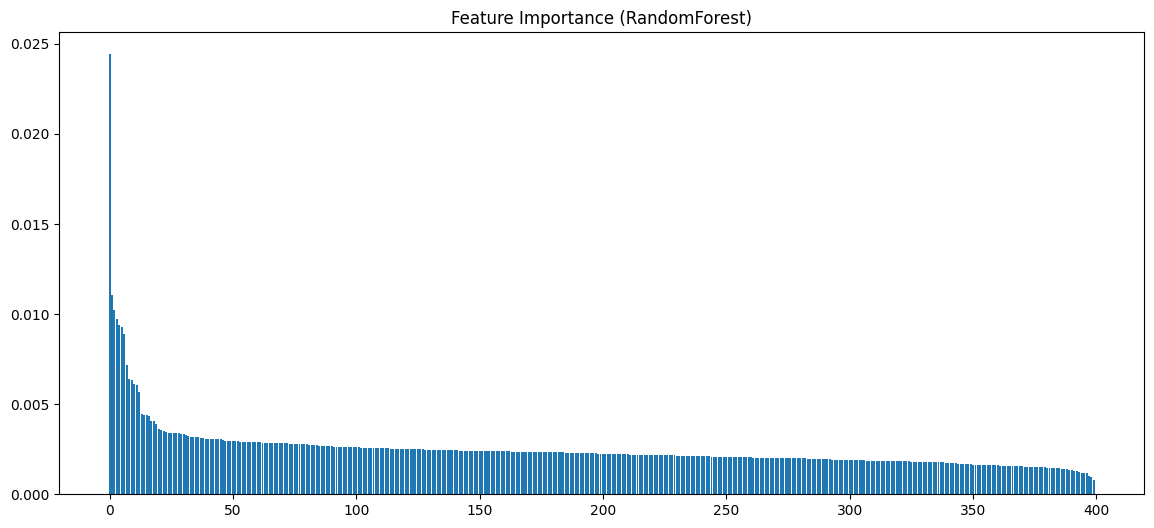

In [114]:
forest = RandomForestClassifier(random_state=69)
forest.fit(data_train_strat, data_class_train)
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(14, 6))
plt.title("Feature Importance (RandomForest)")
plt.bar(range(400), importances[indices], align="center")
plt.show()

### Analysis conclusion

In the original dataset, we had **400 features**, but not all of them contribute meaningfully to the classification task. To avoid noise, overfitting and unnecessary computations we will perform the following steps::
1. **Feature Importance (RandomForest):**

  We trained a default RandomForest to rank features by importance. The plot shows a steep drop-off - only a small number of features have relatively high importance, while many contribute very little.

  Based on the plot, we choose the **top 50 most important variables**, as they capture most of the informative signal while dropping the low-importance noise. The selected variables can bee seen below.
2. **Dimensionality Reduction with PCA:**

  Although our PCA analysis indicated that individual components explain only a small portion of the variance, some of the top 50 features may still be correlated or redundant. To address this, we will apply **PCA** to reduce dimensionality even further while retaining variance.

3. **Model Choice & Optimization:**

  We will use a **RandomForestClassifier** due to its robustness and ability to model non-linear relationships. We will then optimize all its relevant hyperparameters along with the number of PCA components using **Optuna**, to squeeze out the best possible performance.

In [115]:
top_k = 50
top_features = data_train_strat.columns[indices[:top_k]]

data_train_reduced = data_train_strat[top_features]
data_test_reduced = data_test_strat[top_features]

print("Selected features:")
for col in data_train_reduced.columns:
  print(col)

Selected features:
Input240
Input330
Input293
Input396
Input238
Input2
Input41
Input246
Input40
Input206
Input256
Input150
Input65
Input95
Input137
Input308
Input74
Input303
Input38
Input101
Input58
Input306
Input397
Input21
Input267
Input391
Input295
Input321
Input222
Input102
Input61
Input158
Input360
Input194
Input398
Input25
Input64
Input279
Input351
Input344
Input98
Input193
Input226
Input304
Input285
Input186
Input274
Input82
Input198
Input141


In [116]:
# Note: the following cell runs ~5mins in a standard Google Collab environment.
def objective(trial):
    n_components = trial.suggest_int("n_components", 1, 50)

    n_estimators = trial.suggest_int("n_estimators", 50, 150)
    max_depth = trial.suggest_int("max_depth", 3, 20)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)

    pipeline = Pipeline([
        ("pca", PCA(n_components=n_components)),
        ("clf", RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            random_state=420
        ))
    ])

    score = cross_val_score(
        pipeline,
        data_train_reduced, data_class_train,
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=69),
        scoring="accuracy"
    ).mean()

    return score

study = optuna.create_study(
    direction="maximize",
    study_name="Maximize accuracy of RandomForestClassifier (with PCA)",
    sampler=optuna.samplers.TPESampler(seed=7)
)

study.optimize(objective, n_trials=100)

best_params = study.best_params

print("\nFinal hyperparameters:")
for key, value in best_params.items():
    print(f"{key}: {value}")

clf_pipeline = Pipeline([
    ("pca", PCA(n_components=best_params["n_components"])),
    ("clf", RandomForestClassifier(
        n_estimators=best_params["n_estimators"],
        max_depth=best_params["max_depth"],
        min_samples_split=best_params["min_samples_split"],
        min_samples_leaf=best_params["min_samples_leaf"],
        random_state=420
    ))
])

clf_scores = cross_val_score(clf_pipeline, data_train_reduced, data_class_train, cv=clf_cv, scoring='accuracy')

clf_pipeline.fit(data_train_reduced, data_class_train)
clf_pipeline_acc_train = clf_pipeline.score(data_train_reduced, data_class_train)
clf_pipeline_acc_test = clf_pipeline.score(data_test_reduced, data_class_test)

print("\nClassification model (RandomForestClassifier with PCA):")
print(f'Training accuracy: {clf_pipeline_acc_train:.5f}')
print(f'Test accuracy: {clf_pipeline_acc_test:.5f}')
print(f'Mean CV accuracy: {clf_scores.mean():.5f}')
print(f'Std CV accuracy: {clf_scores.std():.5f}')

[I 2025-06-02 20:24:55,770] A new study created in memory with name: Maximize accuracy of RandomForestClassifier (with PCA)
[I 2025-06-02 20:25:00,644] Trial 0 finished with value: 0.69625 and parameters: {'n_components': 4, 'n_estimators': 128, 'max_depth': 10, 'min_samples_split': 15, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.69625.
[I 2025-06-02 20:25:04,627] Trial 1 finished with value: 0.61625 and parameters: {'n_components': 27, 'n_estimators': 100, 'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.69625.
[I 2025-06-02 20:25:12,011] Trial 2 finished with value: 0.6231249999999999 and parameters: {'n_components': 34, 'n_estimators': 131, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.69625.
[I 2025-06-02 20:25:15,073] Trial 3 finished with value: 0.611875 and parameters: {'n_components': 46, 'n_estimators': 71, 'max_depth': 11, 'min_samples_split': 19, 'min_samples_leaf': 1}. Be


Final hyperparameters:
n_components: 5
n_estimators: 98
max_depth: 15
min_samples_split: 6
min_samples_leaf: 1

Classification model (RandomForestClassifier with PCA):
Training accuracy: 0.99250
Test accuracy: 0.80000
Mean CV accuracy: 0.76687
Std CV accuracy: 0.02060


### Classification Model Analysis
We have achieved the following:
- **Training Accuracy:** 0.993
- **Test Accuracy:** 0.800
- **Cross-validated Accuracy:** 0.767 ± 0.020

This model shows very strong training performance, indicating it fits the training data well (probably too well). However, the test accuracy drops to 80%, and the cross-validation mean is around 77% with a small standard deviation (±2%), suggesting mild overfitting, but mostly stable generalization. Overall, it's a well-tuned model with decent performance.

## Task 3 - More advanced regression

Here, we use Lasso regression as it performs  automatic feature selection by driving less important coefficients to zero. This is particularly useful in our high-dimensional dataset (400 input features), where many variables may be irrelevant or redundant. To optimize the regularization strength (alpha), we use `GridSearchCV`, which evaluates model performance over a range of values using cross-validation to find the best trade-off between bias and variance.

In [117]:
# Note: the following cell runs ~2mins in a standard Google Collab environment.
reg_grid = GridSearchCV(
    Lasso(fit_intercept=True, random_state=123, max_iter=10000),
    param_grid={"alpha": np.logspace(-4, 1, 100)},
    cv=reg_cv,
    scoring="r2"
)

reg_grid.fit(data_train_def, data_output_train)

best_lasso = reg_grid.best_estimator_
best_alpha = reg_grid.best_params_['alpha']
selected_features = np.where(best_lasso.coef_ != 0)[0]

print("Best hyperparameters:")
print(f'Alpha: {best_alpha}')
print(f'# Selected features: {len(selected_features)}')
for id in selected_features:
  print(data_train_def.columns[id])

reg_scores = cross_val_score(best_lasso, data_train_def, data_output_train, cv=reg_cv, scoring='r2')

print("\nRegression model (Lasso):")
print(f'Training R²: {best_lasso.score(data_train_def, data_output_train)}')
print(f'Test R²: {best_lasso.score(data_test_def, data_output_test)}')
print(f'Mean CV R²: {reg_scores.mean()}')
print(f'Std CV R²: {reg_scores.std()}')

Best hyperparameters:
Alpha: 0.10722672220103231
# Selected features: 42
Input18
Input41
Input59
Input65
Input78
Input83
Input94
Input103
Input112
Input132
Input136
Input147
Input156
Input167
Input173
Input184
Input193
Input194
Input198
Input204
Input223
Input232
Input235
Input236
Input241
Input250
Input262
Input281
Input285
Input286
Input292
Input295
Input298
Input304
Input342
Input345
Input347
Input363
Input381
Input387
Input389
Input390

Regression model (Lasso):
Training R²: 0.5001767532003996
Test R²: 0.5423600851852917
Mean CV R²: 0.45982652616152286
Std CV R²: 0.033308571153352895


### Regression Model Analysis
We have achieved the following:
- **Training R²:** 0.500
- **Test R²:** 0.542
- ** Cross-validated R²:** 0.460 ± 0.033

This model achieves moderate training performance, indicating that it captures the underlying structure of the data without overfitting. Notably, the test R² improves to ~0.54, suggesting good generalization. The cross-validation score is consistent and stable, with a small standard deviation (±3.3%), further supporting the model’s robustness. Overall, this Lasso model is a solid, well-regularized regression solution that generalizes better than the baseline.

## Final Estimate Function

In [120]:
def estimate():
  df = pd.read_csv("validation_data.csv", sep=';', quotechar='"')

  data = df.drop(columns=['Class', 'Output']).copy()
  data_class = df['Class'].copy()
  data_output = df['Output'].copy()

  return (reg_baseline.score(data, data_output),
         clf_baseline.score(data, data_class),
         best_lasso.score(data, data_output),
         clf_pipeline.score(data, data_class))